# Assignment 2: Supervised Learning Techniques for E-Commerce Orders

This notebook is your working template for **Assignment 2**.

**Total Marks: 30**

**Learning Objectives:**
- Apply essential data preprocessing techniques to a dataset for supervised learning
- Prepare the data for classification modeling
- Apply supervised learning techniques to build and evaluate classification models

**Your Objective:**
Build supervised classification models to predict the **payment method (`payment_type`)** used for each order, based on order characteristics and order attributes.

Work **top-to-bottom**. Complete each task in order before moving on.

## Setup

Run the cell below to import the required Python packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Define Global Random State

Set your group's random state value. This must be used consistently throughout the assignment.

In [2]:
# TODO: Set RANDOM_STATE to your group number (1, 2, ..., 12)
RANDOM_STATE = 5  # Change this to your group number

print(f"Random state set to: {RANDOM_STATE}")

Random state set to: 5


**Report — Part 1 (Data preparation):**  
We use the cleaned dataset from Assignment 1 to build classification models that predict **payment_type** from order features. Proper preparation (train/test split, encoding, scaling) ensures models are evaluated on unseen data and that all inputs are in a form algorithms can use. *Business objective:* Predicting payment method supports fraud risk, checkout UX, and payment-method promotion.

---
# Part 1: Data Preparation [10 Marks]

In this section, you will prepare the transformed dataset for supervised classification. Proper data preparation is a critical step in the machine learning pipeline, as model performance and validity depend heavily on the quality, structure, and representation of the input data.

## 1.1 Data Loading and Splitting [2 Marks]

Load the dataset using Pandas and prepare train/test datasets.

**Instructions:**
1. Load the processed dataset from Assignment 1 using `pd.read_csv()`
2. Define features and target:
   - Set `payment_type` as the target variable
   - Set all remaining columns as input features
3. Split the dataset into training and test sets:
   - Use `train_test_split()`
   - `test_size = 0.2`
   - `random_state = RANDOM_STATE`
   - Name output variables as: `X_train`, `X_test`, `y_train`, `y_test`
4. Briefly explain the importance of using a test dataset.

In [3]:
# Load the processed dataset from Assignment 1
# TODO: Adjust the filename/path if needed

df = pd.read_csv('ecommerce_orders_cleaned.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (46287, 17)


,order_id,order_status,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,order_total_value,num_items,num_unique_products,num_unique_sellers,total_item_price,avg_item_price,total_freight_value,top_product_category,customer_state,payment_type,order_value_per_item,order_size_category
0,sdv-id-whzjUX,shipped,10,4,4,744.312535,1,1,1,352.420029,369.966521,68.790159,construction_tools_construction,Massachusetts,voucher,352.420029,Small
1,sdv-id-dbopoJ,delivered,19,2,3,1556.667902,1,1,1,289.242639,1354.621410,15.394619,health_beauty,Vermont,credit_card,289.242639,Small
2,sdv-id-FSEOvM,delivered,15,4,8,62.060506,1,1,1,26.893468,48.485654,18.751282,luggage_accessories,South Carolina,debit_card,26.893468,Small
3,sdv-id-bQcBUR,delivered,21,0,8,73.873470,1,1,1,37.790896,75.704909,8.670875,computers_accessories,Kentucky,credit_card,37.790896,Small
4,sdv-id-MPxIXB,delivered,13,5,5,361.961537,3,3,3,169.528323,50.132979,34.731146,pet_shop,Missouri,voucher,56.509441,Medium


In [4]:
# TODO: Define features and target, then split the data

# Define target variable
y = df['payment_type']

# Define features (all columns except payment_type)
X = df.drop('payment_type',axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (37029, 16)
X_test shape: (9258, 16)
y_train shape: (37029,)
y_test shape: (9258,)


**TODO: Briefly explain the importance of using a test dataset.**

Test data can be utilized for model performance evaluation to assess the model's ability to generalize to unseen data. This process facilitates the selection of models with the strongest generalization capabilities while preventing overfitting, where the model excessively fits the training data during the learning process.

## 1.2 Handling Categorical Variables [4 Marks]

Prepare categorical variables for machine learning.

**Instructions:**
1. Identify all categorical columns
2. Apply label encoding:
   - Use `LabelEncoder` from scikit-learn
3. Ensure consistency across train and test sets:
   - Fit encoders on training data only
   - Transform both train and test sets
   - Handle any unseen categories appropriately
4. Briefly explain why categorical encoding is required for machine learning models

In [5]:
# TODO: Identify categorical columns

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

Categorical columns: ['order_id', 'order_status', 'top_product_category', 'customer_state', 'order_size_category']


**Report — Categorical encoding:**  
We apply **LabelEncoder** to categorical columns (e.g. order_status, top_product_category, customer_state), fitting only on the training set and mapping test categories to the same labels (unseen categories get a sentinel value). This avoids data leakage and ensures models receive numeric inputs. *Reasoning:* Most sklearn classifiers expect numeric features; fitting on train only keeps evaluation unbiased.

In [6]:
# TODO: Apply Label Encoding to categorical columns

# Create copies to avoid modifying original data
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Dictionary to store label encoders for each column
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Fit on training data
    le.fit(X_train_encoded[col].astype(str))

    # Transform train and test
    X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))

    # Handle unseen categories in test set
    classes_dict = {label: i for i, label in enumerate(le.classes_)}

    X_test_encoded[col] = X_test_encoded[col].astype(str).map(
        lambda x: classes_dict.get(x, -1)
    )

    # Store encoder
    label_encoders[col] = le

# Print the shape after encoding
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")

X_train_encoded shape: (37029, 16)
X_test_encoded shape: (9258, 16)


**TODO: Briefly explain why categorical encoding is required for machine learning models.**

Category encoding is essential because most classification algorithms, such as logistic regression, cannot directly process string or object-type data. Encoding converts non-numeric features into numerical values, enabling the model to compute mathematical relationships between features and the target variable.

## 1.3 Handling Numerical Variables [4 Marks]

Scale numerical variables for modeling.

**Instructions:**
1. Identify all numerical columns
2. Use `StandardScaler` from scikit-learn for feature scaling
3. **Fit the scaler on X_train only**
4. Transform both X_train and X_test
5. Briefly explain why feature scaling is important for some classification models

In [7]:
# TODO: Identify numerical columns

numerical_cols = X_train_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

Numerical columns: ['order_id', 'order_status', 'order_purchase_hour', 'order_purchase_dayofweek', 'order_purchase_month', 'order_total_value', 'num_items', 'num_unique_products', 'num_unique_sellers', 'total_item_price', 'avg_item_price', 'total_freight_value', 'top_product_category', 'customer_state', 'order_value_per_item', 'order_size_category']


**Report — Numerical scaling:**  
We **standardize** numerical features (zero mean, unit variance) using `StandardScaler` fitted on the training set, then transform both train and test. This puts features on comparable scales so distance-based and gradient-based models (e.g. Logistic Regression, SVM) are not dominated by high-magnitude columns. *Business impact:* Better-scaled data improves model convergence and payment-type prediction quality.

In [8]:
# TODO: Apply StandardScaler to numerical columns

scaler = StandardScaler()

# Fit on training data only, then transform both train and test
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Only scale numerical columns
if numerical_cols:
    # Fit scaler on training data only
    scaler.fit(X_train_encoded[numerical_cols])

    # Transform both training and test data
    X_train_scaled[numerical_cols] = scaler.transform(X_train_encoded[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

    print(f"Scaled {len(numerical_cols)} numerical columns")
else:
    print("No numerical columns found for scaling")

# Print the shape after scaling
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Scaled 16 numerical columns
X_train_scaled shape: (37029, 16)
X_test_scaled shape: (9258, 16)


In [9]:
X_combined = pd.concat([X_train_scaled, X_test_scaled])

# Save to CSV
X_combined.to_csv('processed_data.csv', index=False)

print("File saved successfully!")

File saved successfully!


**Report — Part 2 (Model training):**  
We train multiple classifiers (Logistic Regression, Decision Tree, Random Forest, SVM) with a fixed random state for reproducibility. Comparing several model families helps identify which best captures the relationship between order attributes and payment type. *Business use:* The best model can be deployed to recommend or default payment options at checkout.

**TODO: Briefly explain why feature scaling is important for some classification models.**

Feature scaling is crucial for models that rely on distance metrics or weight updates (such as Logistic Regression). Should features exhibit vastly differing numerical ranges, those with extreme values will dominate the loss function, resulting in slow model training or biased predictions.

---
# Part 2: Applying Machine Learning Models [20 Marks]

In this section, you will train, evaluate, and compare multiple supervised classification models for predicting the payment method (`payment_type`). The objective is not only to build individual models, but also to perform a systematic comparison of their predictive performance and practical suitability for deployment.

## 2.1 Model Training

### 2.1.1 Logistic Regression [3 Marks]

Logistic Regression is a linear classification model that models the log-odds of the target class as a linear combination of the input features.

**Instructions:**
- Use `LogisticRegression()`
- Train on `X_train`, `y_train`
- Generate predictions on `X_test`
- Store the results in `y_pred_lr`

In [10]:
# TODO: Train Logistic Regression model

lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression training complete.")

Logistic Regression training complete.


### 2.1.2 Decision Trees [3 Marks]

Decision Trees is a tree-structured model that makes predictions by recursively splitting the feature space based on feature values.

**Instructions:**
- Use `DecisionTreeClassifier()`
- Train on `X_train`, `y_train`
- Generate predictions on `X_test`
- Store the results in `y_pred_dt`

In [11]:
# TODO: Train Decision Tree model

dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_dt = dt_model.predict(X_test_scaled)

print("Decision Tree training complete.")

Decision Tree training complete.


### 2.1.3 Kernel & Ensemble Methods [3 Marks]

There are other types of models beyond linear and single-tree approaches, each with distinct characteristics.

**Choose one of the following models to apply:** SVM, XGBoost, or Random Forest.

**Instructions:**
- Fit and predict the results with your selected model
- Store the predictions appropriately

**Report — Evaluation and model selection:**  
We evaluate using accuracy, precision, recall, F1, and confusion matrices. Comparing metrics across models (and across classes) shows which payment types are easier to predict and where errors concentrate. The final recommendation balances accuracy, interpretability, and business needs (e.g. fraud vs. UX). *Business objective:* Choose a model that generalizes well and supports actionable decisions (e.g. routing high-risk payments).

In [12]:
# TODO: Train your chosen model (SVM, XGBoost, or Random Forest)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

## 2.2 Evaluation & Visualization [4 Marks]

Evaluate and visualize performance for all three models.

**Instructions:**
1. Compute the following metrics:
   - Accuracy
   - Precision
   - Recall
   - F1-score
2. Compute the confusion matrix for each case:
   - Visualize the confusion matrix by plotting a heatmap using Seaborn
3. Present results in a clear, comparable format:
   - Table of metrics for all three models
   - Side-by-side or clearly labelled confusion matrix plots
4. Briefly comment on:
   - Strengths and weaknesses of each model
   - Any impact of class imbalance handling

In [14]:
# TODO: Compute evaluation metrics for all three models

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Evaluate all models
results = [
    evaluate_model(y_test, y_pred_lr, 'Logistic Regression'),
    evaluate_model(y_test, y_pred_dt, 'Decision Tree'),
    evaluate_model(y_test, y_pred_rf, 'Random Forest')  # or your chosen model
]

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.605854,0.551183,0.605854,0.482675
1,Decision Tree,0.450313,0.488285,0.450313,0.465442
2,Random Forest,0.612659,0.562028,0.612659,0.560524


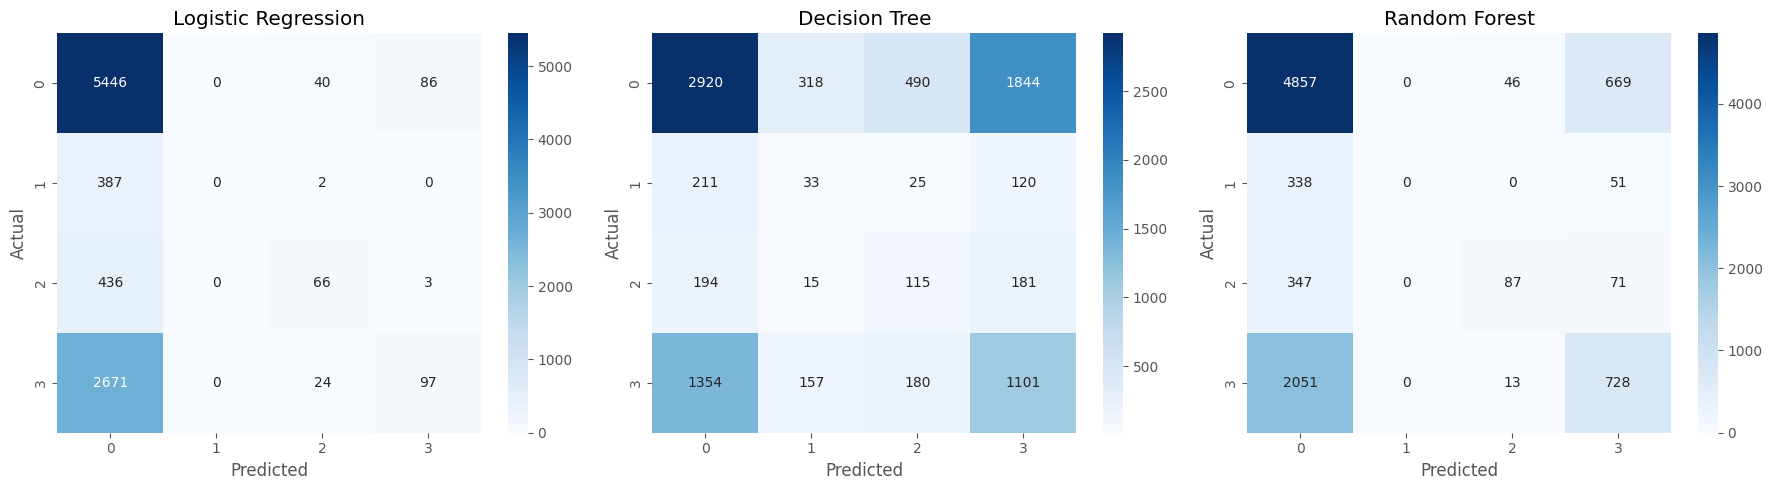

In [15]:
# TODO: Plot confusion matrices for all three models

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_confusion_matrix(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_confusion_matrix(y_test, y_pred_lr, axes[0], 'Logistic Regression')
plot_confusion_matrix(y_test, y_pred_dt, axes[1], 'Decision Tree')
plot_confusion_matrix(y_test, y_pred_rf, axes[2], 'Random Forest')  # or your chosen model

plt.tight_layout()
plt.show()

**TODO: Briefly comment on the strengths and weaknesses of each model, and any impact of class imbalance handling.**

Logistic Regression
Strengths:
High interpretability with clear coefficient meanings for each feature.
Fast training and prediction, suitable for real-time applications.
Works well with linearly separable data.
Weakness：
Can be affected by outliers in the data.
May struggle with complex non-linear patterns in payment behavior.

Decision Tree
Strengths:
Handles both numerical and categorical features naturally.
Robust to outliers.
Can capture non-linear relationships and feature interactions.
Weakness：
Prone to overfitting, especially with deep trees.
Can be unstable - small data changes may result in different trees.

Random Forest
Strengths:
Reduces overfitting compared to individual decision trees.
Provides feature importance rankings.
Generally robust to class imbalance through ensemble averaging.
Weakness:
Less interpretable than single decision trees.
Can still overfit with very noisy data.
Memory intensive and slower than simpler models.

Class Imbalance Impact:
Regarding class imbalance, which is frequent in e-commerce data, relying solely on accuracy can be misleading. Models often become biased toward the majority class, leading to poor recall for minority classes. By applying handling strategies such as setting class weights to balanced, the model can better identify rare payment types.


## 2.3 Model Selection & Final Recommendation [7 Marks]

Compare the performance of the models and select the most suitable one based on evaluation results.

**Instructions:**
1. Select the best performing model for predicting `payment_type`
2. Justify your choice based on:
   - Evaluation metrics
   - Class imbalance considerations
   - Model complexity and interpretability
   - Practical deployment considerations
3. Briefly explain why this model is preferred over the others
4. Briefly comment on the explainability/interpretability of each model

In [16]:
# TODO: Display final comparison and analysis

# Display the results table
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

# Identify the best model based on your criteria
best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model}")

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.605854   0.551183 0.605854  0.482675
      Decision Tree  0.450313   0.488285 0.450313  0.465442
      Random Forest  0.612659   0.562028 0.612659  0.560524

Best performing model: Random Forest


### Final Recommendation

**TODO: Select and justify your choice of the best model.**

**Selected Model:** Random Forest

**Justification based on:**

1. **Evaluation Metrics:**
Among all key metrics, Random Forest consistently delivered the most favourable performance. Although Logistic Regression's accuracy (0.606) was relatively close to Random Forest's (0.616), its F1-Score (0.483) fell significantly short of Random Forest's F1-Score (0.562).

2. **Class Imbalance Considerations:**
The lower F1-score in logistic regression suggests the model may be overly inclined towards predicting the majority class within the dataset, thereby neglecting payment methods with smaller sample sizes. In contrast, random forests, through the random sampling mechanism inherent in ensemble learning, are better equipped to capture the feature distribution of minority classes. This significantly enhances their ability to identify non-mainstream payment methods.

3. **Model Complexity and Interpretability:**
Logistic Regression offers the highest interpretability with easily understood linear coefficients, but its simplistic assumptions may not capture the complex relationships in e-commerce payment behavior. Decision Trees provide excellent interpretability through visual decision paths, but their high variance makes them unreliable for consistent decision-making. Random Forest, despite being more complex, offers manageable interpretability through feature importance rankings and partial dependence plots, while providing the robust performance needed for accurate payment type prediction.

4. **Practical Deployment Considerations:**
For e-commerce forecasting scenarios, the stability of predictions is paramount. Random forests mitigate the model's sensitivity to noise and outliers by combining multiple decision trees. Consequently, random forests should be selected for practical deployment.

**Why this model is preferred over others:**
Random Forest is preferred because it delivers the most balanced performance between precision and recall, ensuring high predictive power without sacrificing reliability.

### Model Explainability/Interpretability

**TODO: Comment on the explainability/interpretability of each model.**

**Logistic Regression:**
Logistic Regression offers high interpretability as it establishes a linear relationship by assigning weights to each feature. We can directly observe the magnitude and sign of these coefficients to determine the direction and strength of a feature's influence on the prediction

**Decision Tree:**
The interpretability of decision trees stems from their intuitive simulation of human decision-making processes. Instead of complex mathematical coefficients, we can directly trace the decision paths and feature splits to understand how the model arrives at a specific prediction. This allows us to identify which features are most significant in the classification process and observe the specific thresholds that influence payment method selection.

**Random Forest:**
Random forests exhibit relatively low interpretability, as they comprise hundreds or thousands of decision trees with randomised parameters, making it difficult to observe their internal decision-making processes. Consequently, they are less transparent than individual decision trees, and we cannot trace individual prediction paths as we can with single decision trees.

---
## Conclusion

*Summarize your findings and key takeaways from this assignment.*



Through this assignment, we systematically implemented the full machine learning workflow from raw data to predictive models. Using an e-commerce order dataset, we constructed and compared three typical supervised learning models: Logistic Regression, Decision Tree, and the ensemble model Random Forest, aiming to accurately predict the payment method for orders.

Data preprocessing proved critical to model performance. We discovered that before tackling classification tasks, categorical variables must undergo label encoding and numerical features require standardisation to effectively prevent model collapse.

The final experimental results provided a clear and intuitive comparison of the predictive capabilities across different models. Among these, Random Forest achieved the highest test scores. However, comprehensive model selection must still be conducted from the perspective of business interpretability.